# Predictions on different data quality

## Data

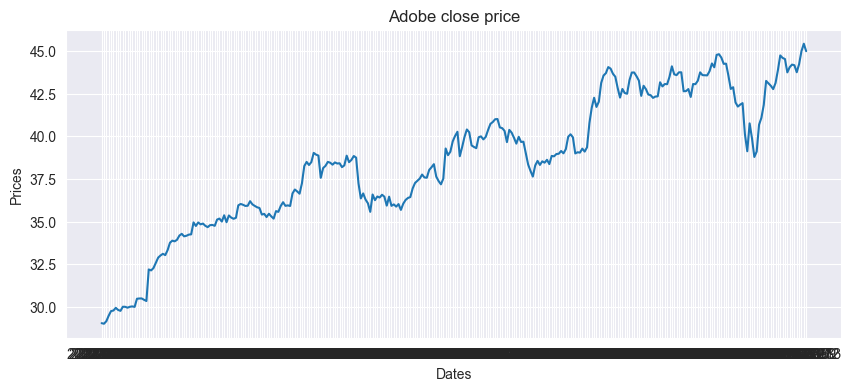

In [1]:
import sys
sys.path.append('..')
from timeseries.timeseries import StockMarketSeries
from timeseries.timeseries import SeriesColumn
from metrics.utils import MetricLevel
from metrics.utils import Strength

stock = StockMarketSeries()
time_series_start = 0
time_series_end = 300
apple = stock.prepare_time_series("Adobe", "../data/apple.csv", time_series_start, time_series_end)
apple_close = stock.create_single_series(SeriesColumn.CLOSE.value)
stock.plot_single_series(apple_close, SeriesColumn.CLOSE)

### Noised data

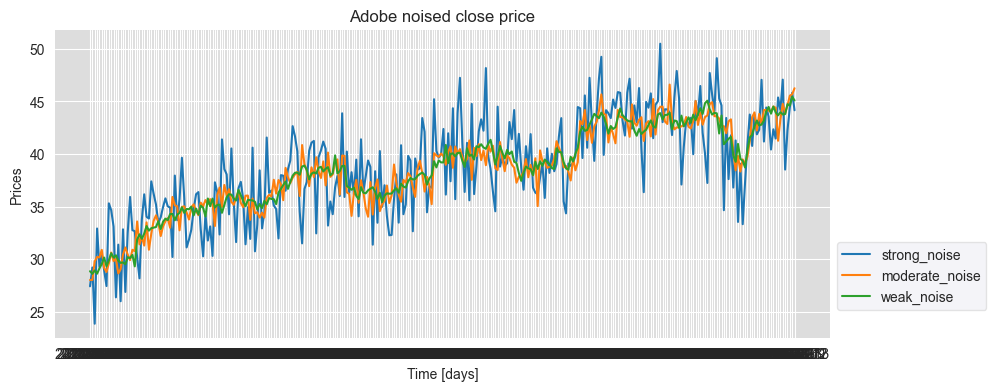

In [2]:
stock.plot_multiple_series("noised close price",
                           strong_noise=stock.series_noised[Strength.STRONG][SeriesColumn.CLOSE],
                           moderate_noise=stock.series_noised[Strength.MODERATE][SeriesColumn.CLOSE],
                           weak_noise=stock.series_noised[Strength.WEAK][SeriesColumn.CLOSE])

## Data quality

### Different noise strength

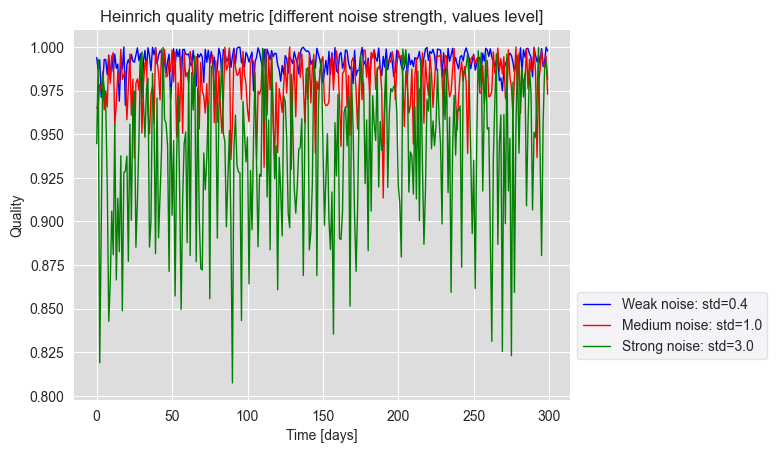

In [3]:
from metrics.utils import Sensitiveness, QualityDifferencesSource
from metrics.correctness import HeinrichCorrectnessMetric

heinrich = HeinrichCorrectnessMetric(
    alpha={Sensitiveness.SENSITIVE: 0.1, Sensitiveness.MODERATE: 0.3, Sensitiveness.INSENSITIVE: 1.0})

weak, medium, strong = heinrich.values_qualities(stock, SeriesColumn.CLOSE, are_different_noises=True, is_alpha=False)
heinrich.draw_heinrich_qualities(stock, weak, medium, strong, QualityDifferencesSource.NOISE_STRENGTH, MetricLevel.VALUES)

### Different alpha value

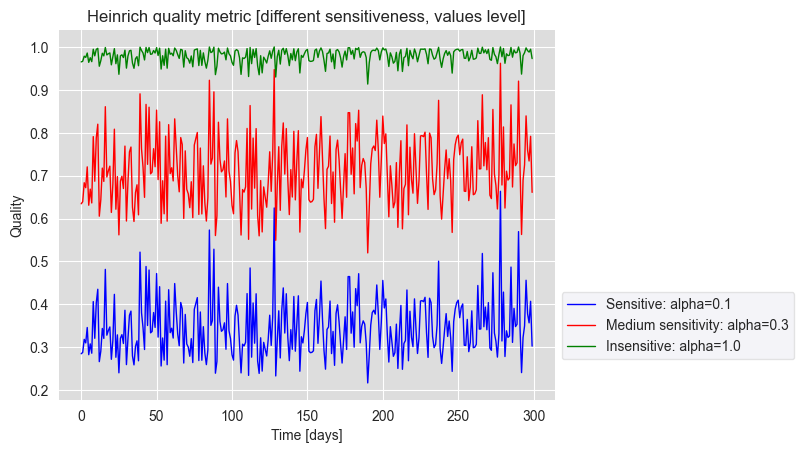

In [4]:
sensitive, medium, insensitive = heinrich.values_qualities(stock, SeriesColumn.CLOSE, are_different_noises=False, is_alpha=True)
heinrich.draw_heinrich_qualities(stock, sensitive, medium, insensitive, QualityDifferencesSource.SENSITIVENESS, MetricLevel.VALUES)

## Statistical methods

In [5]:
from arima import ArimaPrediction
from statistics import mean

prediction_start = 21
prediction_end = 31
arima = ArimaPrediction(apple_close, prediction_start, prediction_end)
arima_weakly_noised = ArimaPrediction(stock.series_noised[Strength.WEAK][SeriesColumn.CLOSE], prediction_start, prediction_end)
arima_moderately_noised = ArimaPrediction(stock.series_noised[Strength.MODERATE][SeriesColumn.CLOSE], prediction_start, prediction_end)
arima_strongly_noised = ArimaPrediction(stock.series_noised[Strength.STRONG][SeriesColumn.CLOSE], prediction_start, prediction_end)

def present_arima(model, order):
    prediction, elapsed_time = model.extrapolate(order)
    model.plot_extrapolation(prediction)
    model.print_elapsed_time(elapsed_time)
    model.print_rms(prediction)

def show_average_elapsed_time(model, order):
    iterations = 10
    elapsed_times = []
    for i in range(iterations):
        prediction, elapsed_time = model.extrapolate(order)
        elapsed_times.append(elapsed_time)
    print(f"Average time of {iterations} iterations: {mean(elapsed_times)} [ms]")


## AR(5)

### weakly noised

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is ava

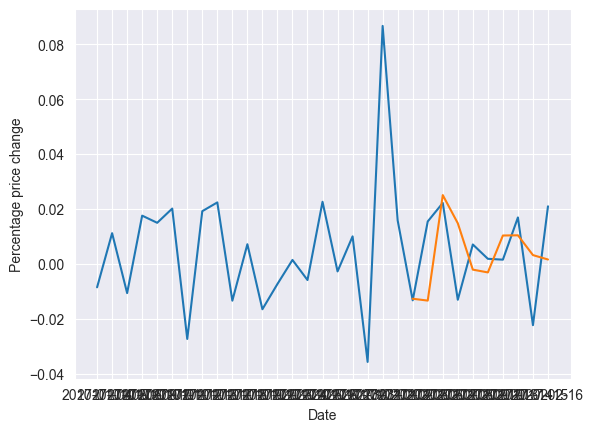

Execution time: 874.83 [ms]
RMS: 0.017 


In [6]:
order = (5,0,0)
present_arima(arima_weakly_noised, order)

In [7]:
show_average_elapsed_time(arima_weakly_noised, order)

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is ava

Average time of 10 iterations: 848.34826 [ms]


### moderately noised

In [8]:
show_average_elapsed_time(arima_moderately_noised, order)

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimiza

Average time of 10 iterations: 843.18597 [ms]


C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maciek\Desktop\Magisterka\project\predictions\arima.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_with_prediction = data_with_prediction.append(prediction_series)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information

### strongly noised

In [9]:
show_average_elapsed_time(arima_strongly_noised, order)

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is ava

Average time of 10 iterations: 854.68819 [ms]


C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maciek\Desktop\Magisterka\project\predictions\arima.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_with_prediction = data_with_prediction.append(prediction_series)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information

## ARIMA(5,5)

### Weakly noised

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

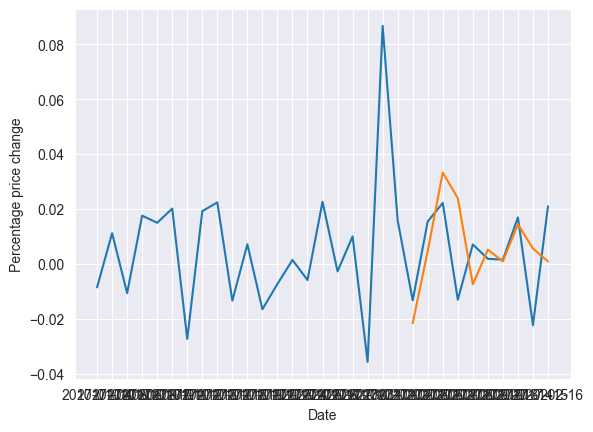

Execution time: 1900.31 [ms]
RMS: 0.018 


In [10]:
order = (5,0,5)
present_arima(arima_weakly_noised, order)

In [11]:
show_average_elapsed_time(arima_weakly_noised, order)

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

Average time of 10 iterations: 1792.94109 [ms]


C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maciek\Desktop\Magisterka\project\predictions\arima.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_with_prediction = data_with_prediction.append(prediction_series)


### Moderately noised

In [12]:
show_average_elapsed_time(arima_moderately_noised, order)

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible startin

Average time of 10 iterations: 1824.76558 [ms]


C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Maciek\Desktop\Magisterka\project\predictions\arima.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_with_prediction = data_with_prediction.append(prediction_series)


### Strongly noised

In [13]:
show_average_elapsed_time(arima_strongly_noised, order)

C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maciek\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

Average time of 10 iterations: 1831.02491 [ms]


## Reservoir computing

In [15]:
from predictions.reservoir import Reservoir

reservoir_weakly_noised = stock.series_noised[Strength.WEAK][SeriesColumn.CLOSE]
reservoir_moderately_noised = stock.series_noised[Strength.MODERATE][SeriesColumn.CLOSE]
reservoir_strongly_noised = stock.series_noised[Strength.STRONG][SeriesColumn.CLOSE]
prediction_start = 220
prediction_end = 300

def perform_reservoir(model):
    reservoir = Reservoir(model, prediction_start, prediction_end)
    reservoir.normalize()
    X, y, res, X_test, y_test, elapsed_time = reservoir.extrapolate()
    reservoir.plot(X, y, res, X_test, y_test)

def show_average_elapsed_time_r(model):
    iterations = 10
    elapsed_times = []
    reservoir = Reservoir(model, prediction_start, prediction_end)
    reservoir.normalize()
    for i in range(iterations):
        X, y, res, X_test, y_test, elapsed_time = reservoir.extrapolate()
        elapsed_times.append(elapsed_time)
    print(f"Average time of {iterations} iterations: {mean(elapsed_times)} [ms]")

### Weakly noised

                   y
date                
2017-01-03  0.014657
2017-01-04  0.000000
2017-01-05  0.019030
2017-01-06  0.000709
2017-01-09  0.030618
...              ...
2018-03-07  0.902711
2018-03-08  0.958295
2018-03-09  0.950193
2018-03-12  1.000000
2018-03-13  0.979655

[300 rows x 1 columns]
Execution time: 110.0 [ms]


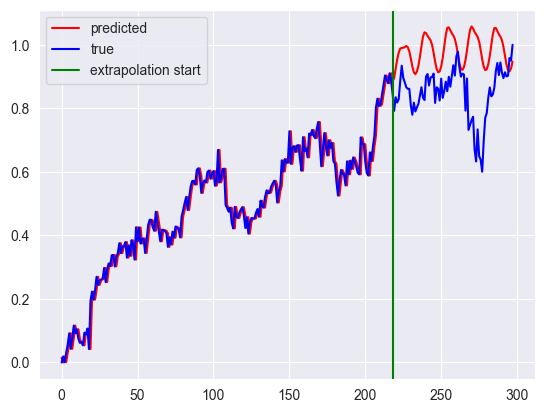

In [16]:
perform_reservoir(reservoir_weakly_noised)

In [18]:
show_average_elapsed_time_r(reservoir_weakly_noised)

                   y
date                
2017-01-03  0.014657
2017-01-04  0.000000
2017-01-05  0.019030
2017-01-06  0.000709
2017-01-09  0.030618
...              ...
2018-03-07  0.902711
2018-03-08  0.958295
2018-03-09  0.950193
2018-03-12  1.000000
2018-03-13  0.979655

[300 rows x 1 columns]
Execution time: 26.0 [ms]
Execution time: 24.0 [ms]
Execution time: 24.64 [ms]
Execution time: 24.0 [ms]
Execution time: 22.72 [ms]
Execution time: 24.0 [ms]
Execution time: 22.91 [ms]
Execution time: 24.0 [ms]
Execution time: 24.0 [ms]
Execution time: 23.0 [ms]
Average time of 10 iterations: 23.926859999999998 [ms]


### Moderately noised

In [17]:
show_average_elapsed_time_r(reservoir_moderately_noised)

                   y
date                
2017-01-03  0.000000
2017-01-04  0.000666
2017-01-05  0.095437
2017-01-06  0.117888
2017-01-09  0.116018
...              ...
2018-03-07  0.852384
2018-03-08  0.893559
2018-03-09  0.943286
2018-03-12  0.950267
2018-03-13  0.981134

[300 rows x 1 columns]


_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 22).

### Strongly noised

In [19]:
show_average_elapsed_time_r(reservoir_strongly_noised)

                   y
date                
2017-01-03  0.133601
2017-01-04  0.200737
2017-01-05  0.000000
2017-01-06  0.340038
2017-01-09  0.203625
...              ...
2018-03-07  0.550565
2018-03-08  0.691057
2018-03-09  0.772554
2018-03-12  0.824415
2018-03-13  0.762353

[300 rows x 1 columns]
Execution time: 26.0 [ms]
Execution time: 24.4 [ms]
Execution time: 24.05 [ms]
Execution time: 23.0 [ms]
Execution time: 24.0 [ms]
Execution time: 22.98 [ms]
Execution time: 24.15 [ms]
Execution time: 23.94 [ms]
Execution time: 23.94 [ms]
Execution time: 25.0 [ms]
Average time of 10 iterations: 24.14664 [ms]
